In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
import seaborn as sb

FACTOR = 1.2
SMALL_SIZE = 8 * FACTOR
MEDIUM_SIZE = 11 * FACTOR
BIGGER_SIZE = 14 * FACTOR

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rc('figure', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('figure',autolayout=True)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=7)



In [2]:

from utils import process_data
data, info = process_data('df-time-agg', keep_coins=5, keep_persons=5, drop_ingeborg=True, drop_lonely=False)
#data[(data['person'] == 'adamF') & (data['coin'] == '0.05EUR') & (data['agg'] == 84)]
#print(data.head)


'''
model = sm.OLS.from_formula('same_side~0+C(person):C(coin)', data=data)
model_bis = sm.OLS.from_formula('same_side~1+C(person):C(coin)', data=data)
X = model.exog
X_bis = model_bis.exog

assert np.all(X == X_bis)

res = []
for i in range(X.shape[1]):
    if np.all(X[:,i] == 0):
        res.append(i)

X_non_sing = np.delete(X, res, axis=1)

print(X_non_sing.shape)
print( np.linalg.matrix_rank(X_non_sing.T@X_non_sing) )
'''


"\nmodel = sm.OLS.from_formula('same_side~0+C(person):C(coin)', data=data)\nmodel_bis = sm.OLS.from_formula('same_side~1+C(person):C(coin)', data=data)\nX = model.exog\nX_bis = model_bis.exog\n\nassert np.all(X == X_bis)\n\nres = []\nfor i in range(X.shape[1]):\n    if np.all(X[:,i] == 0):\n        res.append(i)\n\nX_non_sing = np.delete(X, res, axis=1)\n\nprint(X_non_sing.shape)\nprint( np.linalg.matrix_rank(X_non_sing.T@X_non_sing) )\n"

In [3]:
def deviance_analysis( data, formula, filename, summary=False, force=False ):
    def fit_model():
        model = smf.glm(formula=formula, data=data, family=sm.families.Binomial())
        results = model.fit(disp=True)
        results.save(f'../models/{filename}.pickle')
        summ = results.summary()
        with open(f'../models/{filename}.txt', 'w') as f:
            fit_history = results.fit_history
            f.write( f'Iteration:{fit_history['iteration']}\n' )
            f.write( f'Deviance trajectory:{fit_history['deviance']}\n' )
            f.write(summ.as_text())
        return summ, results

    if force :
        _, results = fit_model()
    else : 
        try : 
            results = sm.load(f'../models/{filename}.pickle')
        except FileNotFoundError:
            _, results = fit_model()

    dic = {}
    dic['formula'] = formula.split('~')[1]
    dic['deviance'] = results.deviance
    dic['aic'] = results.aic
    dic['df_residual'] = results.df_resid
    dic['df_model'] = results.df_model

    if summary:
        print(results.summary())

    return dic, results


formula_cst = 'same_side+diff_side~1'
formula_person = 'same_side+diff_side~1+person'
forumula_person_time = 'same_side+diff_side~1+person+agg'
formula_all_main = 'same_side+diff_side~1+person+agg+coin'
formula_nested = 'same_side+diff_side~0+person:coin'
#formula_nested = 'same_side+diff_side~1+C(person)+C(coin)+C(person):C(coin)'
# this last model takes around 8 minutes to fit (since it needs around 100 iterations)

results = []
dic_cst, results_cst = deviance_analysis(data, formula_cst, 'cst_glm', force=True)
results.append(dic_cst)
dic_person, results_person = deviance_analysis(data, formula_person, 'person_glm', force=True)
results.append(dic_person)
dic_person_time, results_person_time = deviance_analysis(data, forumula_person_time, 'person_time_glm', force=True)
results.append(dic_person_time)
dic_all_main, results_all_main = deviance_analysis(data, formula_all_main, 'all_main_glm', force=True)
results.append(dic_all_main)
dic_nested, results_nested = deviance_analysis(data, formula_nested, 'nested', force=False)
#results.append(dic_nested)

results_df = pd.DataFrame(results)
results_df['aic'] = results_df['aic'] - results_df['aic'].min()
print(results_df)



             formula     deviance         aic  df_residual  df_model
0                  1  3942.125982  187.839071         3408         0
1           1+person  3676.201660   13.914749         3362        46
2       1+person+agg  3660.286911    0.000000         3361        47
3  1+person+agg+coin  3602.256800   25.969888         3319        89


In [4]:
def compare_lr_test( dic, dic_restricted ):
    res = {}
    res['tested_model'] = dic['formula']
    res['restricted_model'] = dic_restricted['formula'] 

    deviance_diff = dic_restricted['deviance'] - dic['deviance']
    df_diff = dic_restricted['df_residual'] - dic['df_residual']
    p_value = 1 - stats.chi2.cdf(deviance_diff, df_diff)
    res['p_value'] = p_value

    return res

print('Table for model comparison : ')
deviance_string = results_df.to_latex(index=False, 
                columns=['formula', 'deviance', 'aic', 'df_model'], 
                header=['Model', 'Deviance', 'AIC', 'Model DF'],
                formatters={'formula': lambda x: r'\texttt{'+x+r'}'},
                float_format='{:.2f}'.format,
                caption='Model comparison for different models.',
                label='tab:model-comparison',
                position='htb',
                column_format='lccc')
caption_index = deviance_string.find(r'\caption')
deviance_string = deviance_string[:caption_index] + r'\centering' + '\n' + deviance_string[caption_index:]
print(deviance_string)

entries = []
entries.append( compare_lr_test( dic_person, dic_cst ) )
entries.append( compare_lr_test( dic_person_time, dic_person ) )
entries.append( compare_lr_test( dic_all_main, dic_person_time ) )
#entries.append( compare_lr_test( dic_nested, dic_coin_pers ) )
table = pd.DataFrame(entries)

print('LLR test table : ')
llr_string = table.to_latex(index=False, 
                columns=['tested_model', 'restricted_model', 'p_value'], 
                header=['Tested model', 'Restricted model', '$p$-value'],
                formatters={'tested_model': lambda x: r'\texttt{'+x+r'}',
                            'restricted_model': lambda x: r'\texttt{'+x+r'}'},
                float_format='{:.2e}'.format,
                caption='Likelihood ratio tests between models.',
                label='tab:llr-comparison',
                position='htb',
                column_format='llc')
caption_index = llr_string.find(r'\caption')
llr_string = llr_string[:caption_index] + r'\centering' + '\n' + llr_string[caption_index:]
print(llr_string)



Table for model comparison : 
\begin{table}[htb]
\centering
\caption{Model comparison for different models.}
\label{tab:model-comparison}
\begin{tabular}{lccc}
\toprule
Model & Deviance & AIC & Model DF \\
\midrule
\texttt{1} & 3942.13 & 187.84 & 0 \\
\texttt{1+person} & 3676.20 & 13.91 & 46 \\
\texttt{1+person+agg} & 3660.29 & 0.00 & 47 \\
\texttt{1+person+agg+coin} & 3602.26 & 25.97 & 89 \\
\bottomrule
\end{tabular}
\end{table}

LLR test table : 
\begin{table}[htb]
\centering
\caption{Likelihood ratio tests between models.}
\label{tab:llr-comparison}
\begin{tabular}{llc}
\toprule
Tested model & Restricted model & $p$-value \\
\midrule
\texttt{1+person} & \texttt{1} & 0.00e+00 \\
\texttt{1+person+agg} & \texttt{1+person} & 6.63e-05 \\
\texttt{1+person+agg+coin} & \texttt{1+person+agg} & 5.09e-02 \\
\bottomrule
\end{tabular}
\end{table}



38
17


Text(0.5, 0.98, 'Coins coefs')

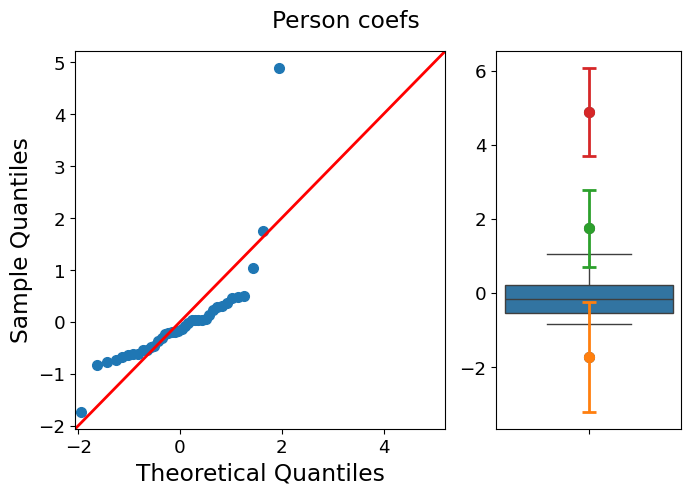

<Figure size 500x500 with 0 Axes>

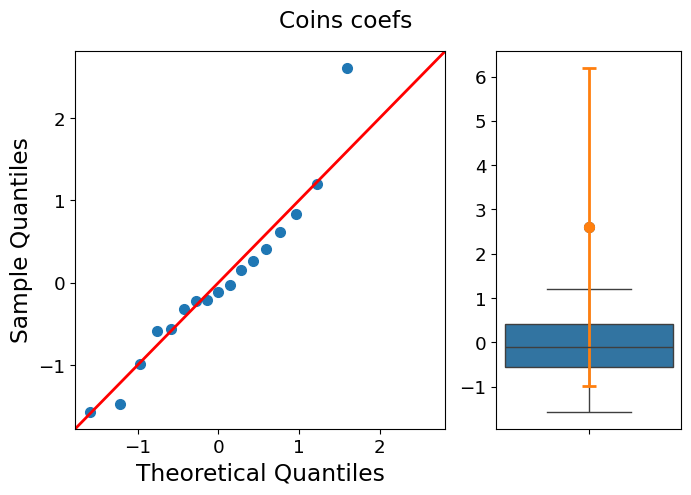

In [5]:
data, info = process_data('df-time-agg', keep_coins=3, keep_persons=3, drop_ingeborg=True)

# get coefficients associated with people main effects
coefs = results_all_main.params
ci_l = coefs - results_all_main.conf_int()[0] 
ci_u = results_all_main.conf_int()[1] - coefs
width = ci_u - ci_l

#plt.figure(figsize=(10, 5))
#plt.errorbar(coefs.index, coefs, yerr=[ci_l.values, ci_u.values], fmt='o', capsize=5, capthick=2)

#print(coefs.abs().sort_values(ascending=False).index[:10])
# print ci associated to biggest coefficients
#print(ci.loc[coefs.abs().sort_values(ascending=False).index[:10]])
#print(ci.loc[coefs.abs().sort_values(ascending=True).index[:10]])

filt_person = coefs[coefs.index.str.match(r'^person\[T\.[^\]:]+\]$')]
filt_coin = coefs[coefs.index.str.match(r'^coin\[T\.[^\]:]+\]$')]
pattern_person = r'^person\[T\.(' + '|'.join(info['common_persons']) + r')\]$'
pattern_coin = r'^coin\[T\.(' + '|'.join(info['common_coins']) + r')\]$'
common_persons = filt_person[ filt_person.index.str.match( pattern_person ) ]
common_coins = filt_coin[ filt_coin.index.str.match( pattern_coin ) ]

def norm(x, mean=None, std = None, return_params=False):
    if mean is None or std is None:
        mean = x.mean()
        std = x.std()
    if return_params:
        return (x - mean) / std, mean, std
    return (x - mean) / std

def unorm(x, mean, std):
    return x * std + mean

print(common_persons.count())
print(common_coins.count())


fig, ax = plt.subplots( 1, 2, figsize=(7, 5), width_ratios=[1, .5])
sm.qqplot(norm(common_persons), line='45', ax=ax[0])
sb.boxplot(norm(common_persons), ax=ax[1])

outliers = ax[1].get_lines()[5].get_ydata() # I found this by inspecting the boxplot
n_person, mean_person, std_person = norm(common_persons, return_params=True)
plt.plot(np.nan, np.nan) # skip blue color in cycler by plotting nothing
for element in outliers:
    unorm_element = unorm(element, mean_person, std_person)
    ind = common_persons[abs(common_persons-unorm_element)<1.0e-10].index[0]
    plt.errorbar(0, element, yerr=norm(ci_u[f'{ind}'], mean=0.0, std=std_person), fmt='o', capsize=5, capthick=2)

fig.suptitle('Person coefs')

plt.figure(figsize=(5, 5))
fig, ax = plt.subplots( 1, 2, figsize=(7, 5), width_ratios=[1, .5])
sm.qqplot(norm(common_coins), line='45', ax=ax[0])
sb.boxplot(norm(common_coins), ax=ax[1])

outliers = ax[1].get_lines()[5].get_ydata()
n_coin, mean_coin, std_coin = norm(common_coins, return_params=True)
plt.plot(np.nan, np.nan) # skip blue color in cycler by plotting nothing
for element in outliers:
    unorm_element = unorm(element, mean_coin, std_coin)
    ind = common_coins[abs(common_coins-unorm_element)<1.0e-10].index[0]
    plt.errorbar(0, element, yerr=norm(ci_u[f'{ind}'], mean=0.0, std=std_coin), fmt='o', capsize=5, capthick=2)

fig.suptitle('Coins coefs')


      heads_heads  tails_heads  N_start_heads_up  N_start_tails_up  same_side  \
2771           27           18                45                55         64   
1544           20           29                49                51         42   
2621           18           29                47                53         42   
2625           37           11                48                52         78   
2377           38           18                55                56         76   
2758           20           32                52                48         36   
2392           32           18                50                50         64   
2264           19           31                50                50         38   
2403           18           31                50                50         37   
2765           14           30                45                55         39   

        N      person     coin  agg  from    to  mean_toss  N_throws  \
2771  100   XiaoyiLin  0.20EUR   14 

C:\Users\Tobia\AppData\Local\Temp\ipykernel_25072\983674411.py:113: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.savefig('../figures/dev_resid_vs_covariates.png', dpi=300)


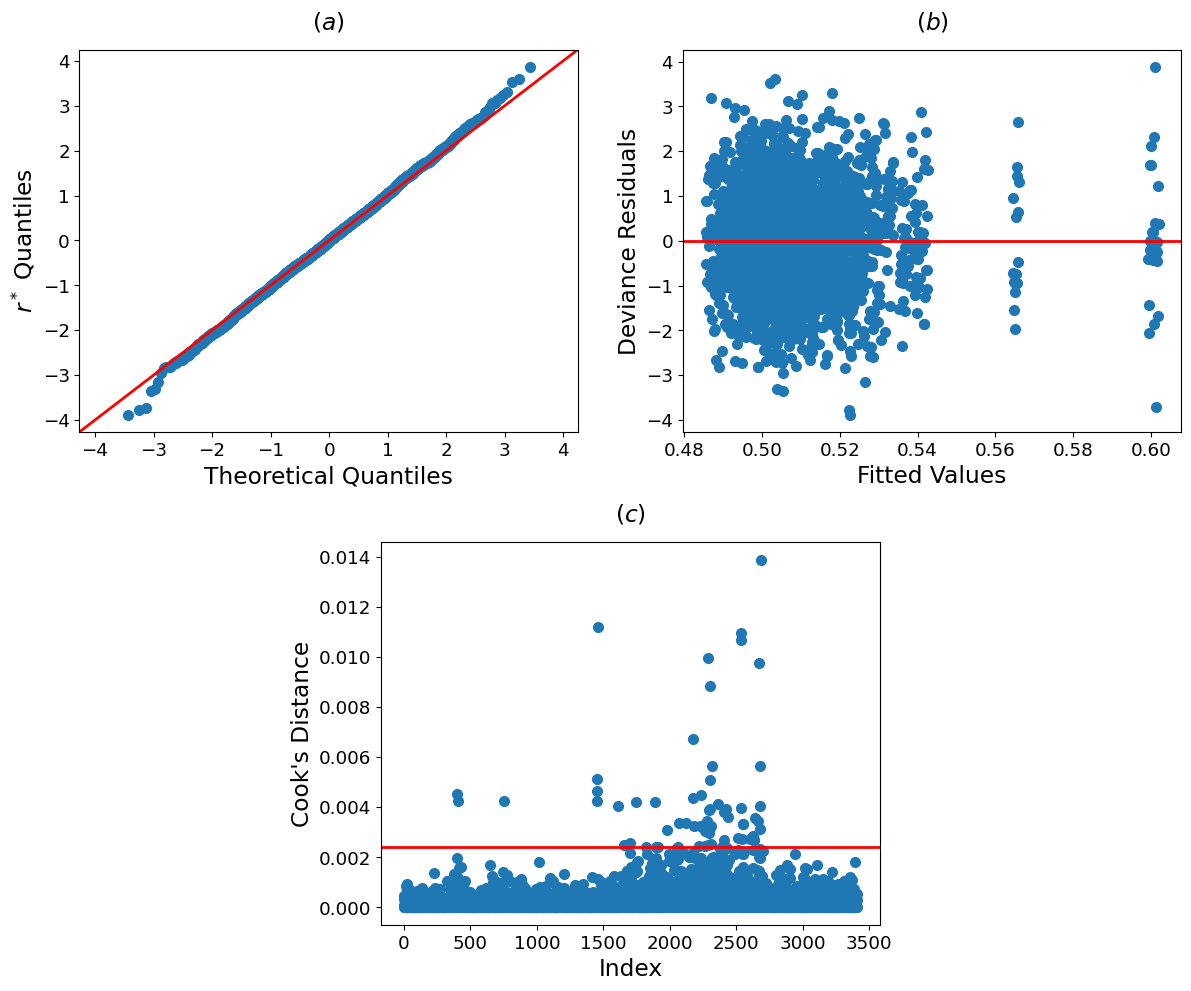

c:\Users\Tobia\miniconda3\envs\regression\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


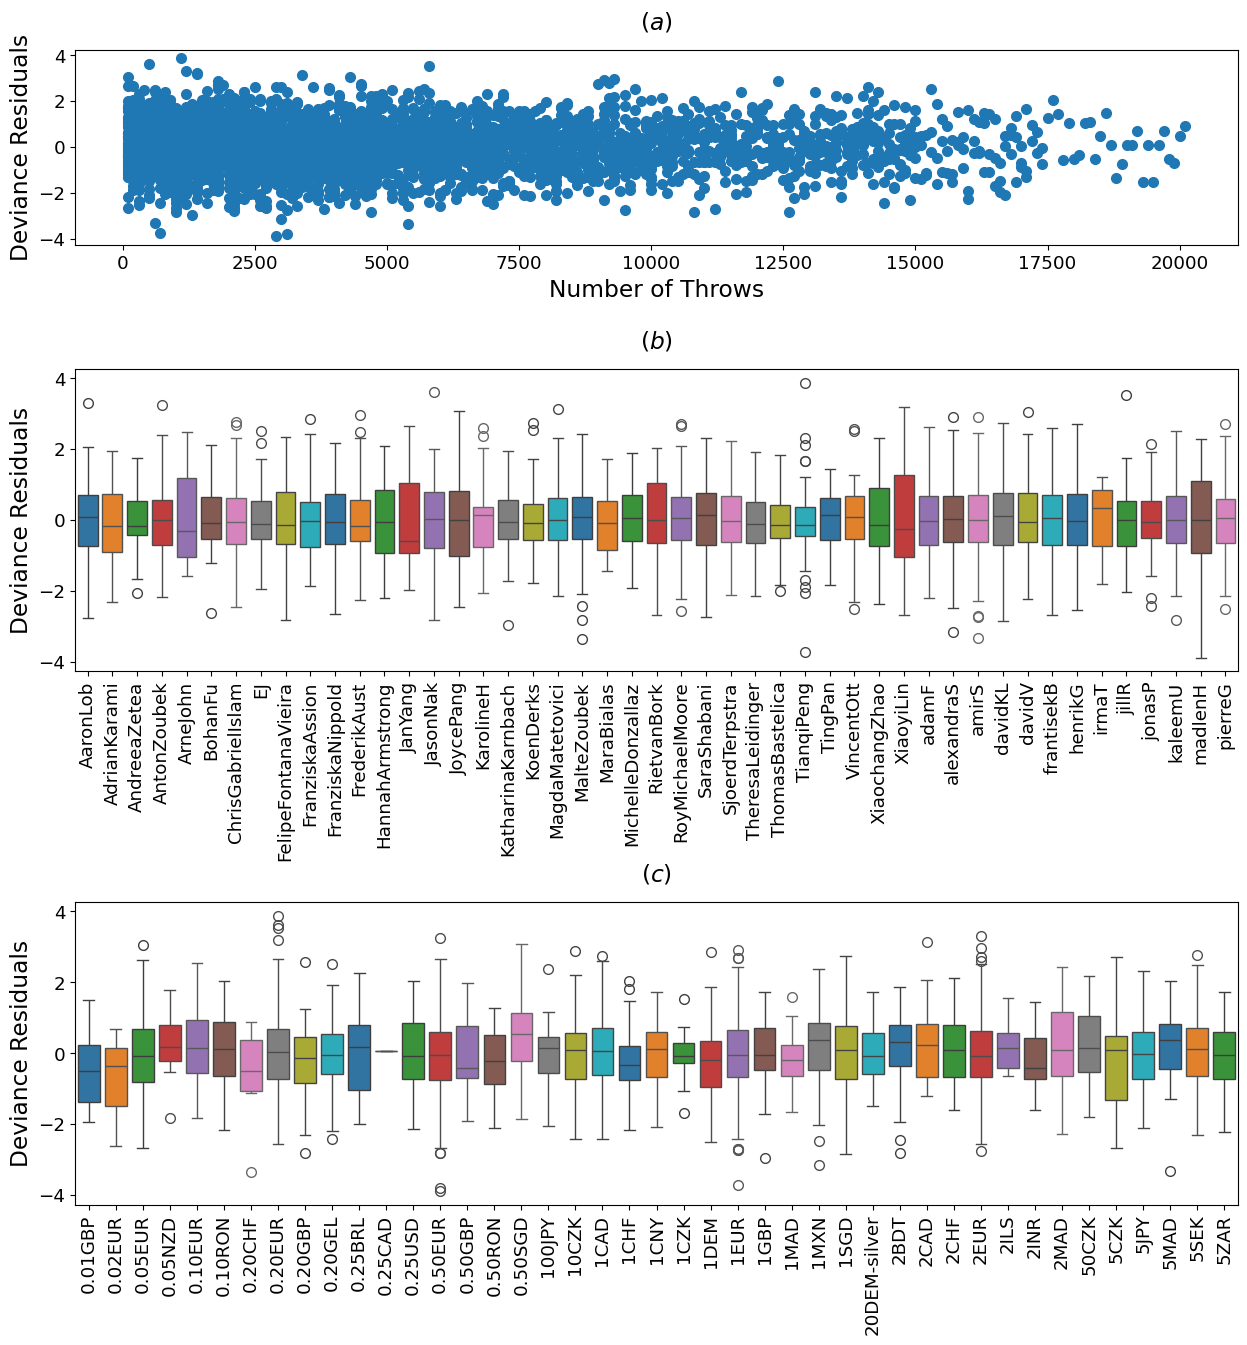

In [20]:
# can add plot of residuals vs fitted values/linear predictor or covariates
# do also as function of person and coin 
# Cook with davi threshold (8/(n-2p)) 

def diagnostic_plots( results, ax=None ):
    if ax is None : 
        fig = plt.figure(figsize=(12, 10), layout='tight')

        gs = GridSpec(2, 4, figure=fig, )
        ax1 = fig.add_subplot(gs[0,0:2])
        ax2 = fig.add_subplot(gs[0,2:])
        ax3 = fig.add_subplot(gs[1,1:-1])
    else : 
        ax1, ax2, ax3 = ax

    influence_inst = results.get_influence()
    leverage = influence_inst.hat_matrix_diag

    #print(max(leverage))
    resid_dev = results.resid_deviance / np.sqrt(1-leverage)
    resid_pea = results.resid_pearson / np.sqrt(1-leverage)
    
    influence = {}
    influence['dav_resid'] = resid_dev + np.log( resid_pea / resid_dev ) / resid_dev
    influence['stud_pea_resid'] = influence_inst.resid_studentized
    influence['leverage'] = leverage
    influence['cooks_d'] = influence_inst.cooks_distance[0]

    #sm.qqplot(influence['stud_pea_resid'], line ='45', ax=ax1)
    sm.qqplot(influence['dav_resid'], line ='45', ax=ax1)
    ax1.set_ylabel('$r^*$ Quantiles')
    ax1.set_title('$(a)$', pad=15)

    #influence_inst.plot_influence(size=20, ax=ax[2])
    #ax[2].set_title('$(c)$', pad=15)
    #ax[2].set_ylabel('Studentized Pearson Residuals')

    fitted = results.fittedvalues
    ax2.scatter( fitted, resid_dev )
    ax2.axhline(0, color='red')
    max_resid = max(np.abs(resid_dev))
    ax2.set_ylim(-1.1*max_resid, 1.1*max_resid)
    ax2.set_xlabel('Fitted Values')
    ax2.set_ylabel('Deviance Residuals')
    ax2.set_title('$(b)$', pad=15)

    # plot cooks distance as function of index
    threshold = 8 / (len(fitted) - 2*results.df_model)
    ax3.scatter( range(len(influence['cooks_d'])), influence['cooks_d'] )
    ax3.axhline(threshold, color='red')
    ax3.set_xlabel('Index')
    ax3.set_ylabel('Cook\'s Distance')
    ax3.set_title('$(c)$', pad=15)

    return [ax1, ax2, ax3], influence

def residual_vs_covariate( results, data, ax=None ):
    if ax is None : 
        fig = plt.figure(figsize=(15, 15), layout='tight')

        gs = GridSpec(11, 1, figure=fig, )
        ax1 = fig.add_subplot(gs[0:2,0])
        ax2 = fig.add_subplot(gs[3:6,0])
        ax3 = fig.add_subplot(gs[8:,0])
        ax = [ax1, ax2, ax3]
    else : 
        ax1, ax2, ax3 = ax

    influence_inst = results.get_influence()
    leverage = influence_inst.hat_matrix_diag

    resid_dev = results.resid_deviance / np.sqrt(1-leverage)
    resid_pea = results.resid_pearson / np.sqrt(1-leverage)

    influence = {}
    influence['dav_resid'] = resid_dev + np.log( resid_pea / resid_dev ) / resid_dev
    influence['stud_pea_resid'] = influence_inst.resid_studentized
    
    influence['leverage'] = leverage
    influence['cooks_d'] = influence_inst.cooks_distance

    for i, (col,lab) in enumerate( zip( ['agg', 'person', 'coin'], ['a','b','c'] ) ):
        df_resid = pd.DataFrame({'dav_resid': influence['dav_resid'], col: data[col]})
        grouped_resid = df_resid.groupby(col)
        
        if col == 'agg':
            ax[i].scatter(data[col]*100, influence['dav_resid'])
            ax[i].set_xlabel('Number of Throws')
        else:
            xticks = []
            for name, group in grouped_resid:
                sb.boxplot(x=group[col], y=group['dav_resid'], ax=ax[i])
                #ax[k].scatter(group[col], group['dav_resid'])
                xticks.append(name)

            ax[i].set_xticks(xticks)
            ax[i].set_xticklabels(xticks, rotation=90)
            ax[i].set_xlabel('')
        ax[i].set_ylabel('Deviance Residuals')
        ax[i].set_title(f'$({lab})$', pad=15)

    return ax


ax, influence = diagnostic_plots( results_person_time )
plt.savefig('../figures/GLM_diagnostics.png', dpi=300)

inds = np.flip( np.argsort(influence['cooks_d']) )
print(data.iloc[inds[:10]])


ax = residual_vs_covariate( results_person_time, data )
plt.savefig('../figures/dev_resid_vs_covariates.png', dpi=300)


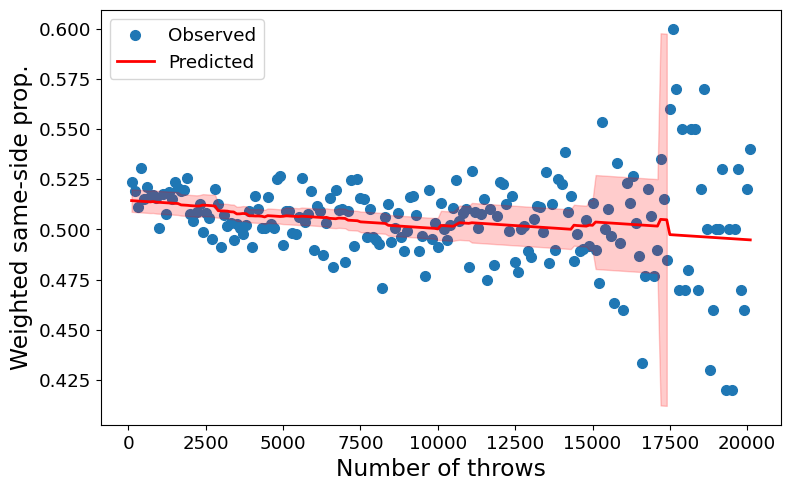

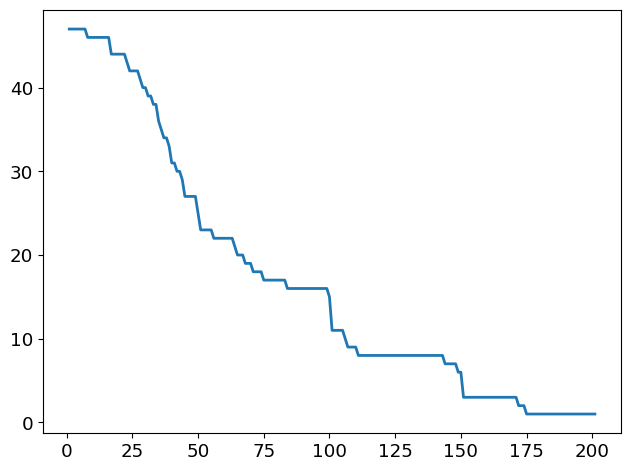

In [11]:
# add 95% CI for the predicted values (since number of people decreases with flips)
from scipy.stats import t

prediction = results_person_time.predict(data)
wheighted_prediction = (prediction * data['N_throws']).groupby(data['agg']).sum() / data['N_throws'].groupby(data['agg']).sum()
pred_se = prediction.groupby(data['agg']).std() / np.sqrt(data['N_throws'].groupby(data['agg']).count())

#data['up_ci'] = results_person_time.get_prediction().summary_frame()['mean_ci_upper']
#data['low_ci'] = results_person_time.get_prediction().summary_frame()['mean_ci_lower']
#print(data['low_ci'].head())
#print('\n Hey', up_ci[:5], low_ci[:5], data['prediction_ste'].head(), '\n hey')
#up_ci = (data['up_ci'] * data['N_throws']).groupby(data['agg']).sum() / data['N_throws'].groupby(data['agg']).sum() #/ np.sqrt(data['N_throws'].groupby(data['agg']).count())
#low_ci = (data['low_ci'] * data['N_throws']).groupby(data['agg']).sum() / data['N_throws'].groupby(data['agg']).sum() #/ np.sqrt(data['N_throws'].groupby(data['agg']).count())


#std_bis = data['prediction_ste'].groupby(data['agg']).mean() / np.sqrt(data['N_throws'].groupby(data['agg']).count())
same_side = data.groupby('agg').agg({'same_side': 'sum'}).values
diff_side = data.groupby('agg').agg({'diff_side': 'sum'}).values 
observation = same_side / (same_side + diff_side)
cum_n_throws = 100*data['agg'].unique()

counts = data['N_throws'].groupby(data['agg']).count()
ind = np.min(np.where(counts == 1))
dfs = counts - 1
alpha = 0.05
t_factors = t.ppf(1 - alpha / 2, dfs)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.scatter(cum_n_throws, observation, label='Observed')
plt.plot(cum_n_throws, wheighted_prediction, label='Predicted', color='red')
#plt.fill_between(cum_n_throws, low_ci, up_ci, color='red', alpha=0.2)
plt.fill_between(cum_n_throws[:ind], wheighted_prediction[:ind] - t_factors[:ind]*pred_se[:ind], \
                 wheighted_prediction[:ind] + t_factors[:ind]*pred_se[:ind], color='red', alpha=0.2)
plt.legend()
plt.xlabel('Number of throws')
plt.ylabel('Weighted same-side prop.')
plt.savefig('../figures/learning_effects.png', dpi=300)


plt.figure()
plt.plot(counts)
